## Polynomial Regression

Here we will generate some fake data and attempt to use gradient to descent to fit a polynomial following the equation below.

\begin{equation}
 Y = \cos{(2\pi X)} + N(0,\sigma^2)\, , \; \; \; \; \; \; \; \;  \; X \in (0,1)
\end{equation}


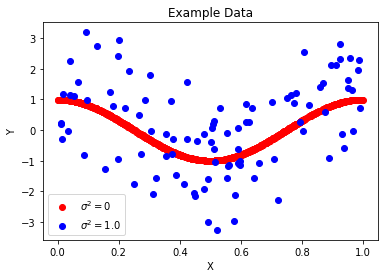

We have a standard cosine phase with the possibility to add additional Gaussian noise which will perturb our waveform up or down, proportional to $\sigma$.

A polynomial regression algorithm is implemented using numpy. The model is able to accept varying degrees of the polynomial we wish to fit (see below equation), where $d$ is the degree of the polynomial. As a side note, consider why we want to use a polynomial in the following form to fit a cosine function.

\begin{equation}
    Y = \theta_0 + \theta_1 X + \theta_2 X^2 ... + \theta_d X^d
\end{equation}

We will investigate the effects of complex models (large d) and investigate potential effects. We will be monitoring the in sample (training error $E_{in}$) and out of sample (test error $E_{out}$).

Since we are performing simple regression, we choose our objective function (loss function) to be the mean squared error between predicted and true.

\begin{equation}
    \mathcal{L}_{MSE} = \frac{1}{N}\sum_{i=1}^N (y_i - \theta^Tx_i)^2
\end{equation}

We also include L2 normalization in order to help mittigate the effects of over fitting which will be discussed later. This regularization can be turned off and on in the code to see effects.

\begin{equation}
    \mathcal{L}_{L2} = \frac{\alpha}{N}\sum_{j=1}^M w_j^2\, , \; \; \; \; \; \; \; \; \; \; \;\alpha = 0.01
\end{equation}





In [ ]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import itertools
import matplotlib.pyplot as plt


# Data generation function. Defined by N samples and the variance of the Gaussian.
# I used pandas as it makes plotting against data very easy.
true_function = lambda x: np.cos(2*np.pi*x)


def getData(N,sigma_squared):
  x = np.array(np.random.uniform(low=0,high=1.0,size=N))
  y = np.array(true_function(x) +  np.random.normal(loc=0.0,scale=np.sqrt(sigma_squared),size=N))
  dataset = pd.DataFrame()
  dataset['x'] = x
  dataset['y'] = y
  return dataset

### Plotting Code

Don't worry about this. Just some plotting code for our experiments we will run.

In [ ]:
def plot_errors_vs_degree(results_df,sigma,N,L2):
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['degree'], results_df['E_out_bar'],color='red',label=r"$\bar{E}_{out}$",alpha=1)
    plt.scatter(results_df['degree'], results_df['E_in_bar'],color='blue',label=r"$\bar{E}_{in}$",alpha=1)

    plt.title(r'E as a function of Polynomial Degree   $\sigma = {0:.3f}$ $N={1:.0f}$  $L2={2}$'.format(sigma,N,L2))
    plt.xlabel('Polynomial Degree')
    plt.ylabel(r'$E$')
    plt.rcParams['legend.fontsize'] = 15
    leg = plt.legend(loc='best')
    for lh in leg.legend_handles:
        lh.set_alpha(1)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_errors_vs_N(results_df):
    grouped = results_df.groupby('N').agg({
        'E_out_bar': 'mean',
        'E_in_bar': 'mean'
    }).reset_index()

    plt.figure(figsize=(8,5))
    plt.scatter(grouped['N'], grouped['E_out_bar'],color='red',label=r"$\bar{E}_{out}$",alpha=1)
    plt.scatter(grouped['N'], grouped['E_in_bar'],color='blue',label=r"$\bar{E}_{in}$",alpha=1)
    plt.xlabel('Training Size N')
    plt.ylabel('Error')
    plt.title('Errors vs Training Size')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)

def plot_sample_fit(results_df):
    for idx, row in results_df.iterrows():
        x_fit, y_fit, y_true, train = row['sample_fits'][0]  # first trial fit

        plt.figure(figsize=(8,5))
        plt.plot(x_fit, y_true, label='True Function', linestyle='--')
        plt.plot(x_fit, y_fit, label='Model Prediction')
        plt.scatter(train['x'], train['y'], color='gray', alpha=0.5, label='Training Data', s=10)
        plt.title(f"Sample Fit (N={row['N']}, degree={row['degree']})")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_errors_vs_sigma(results_df):
    grouped = results_df.groupby('sigma').mean(numeric_only=True)

    plt.figure(figsize=(8, 5))
    plt.plot(grouped.index, grouped['E_out_bar'], 'o-', color='red', label=r"$\bar{E}_{out}$")
    plt.plot(grouped.index, grouped['E_in_bar'], '^-', color='blue', label=r"$\bar{E}_{in}$")
    if 'E_bias' in grouped:
        plt.plot(grouped.index, grouped['E_bias'], '*-', color='darkorange', label=r"$E_{bias}$")

    plt.title(r'Error vs Training Noise $\sigma^2$', fontsize=15)
    plt.xlabel(r'Noise Variance $\sigma^2$', fontsize=13)
    plt.ylabel('Error', fontsize=13)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

### Regression Class


We implement a simple regression class below. At this stage your job is to complete the following:

1. Forward function - we want to return our predicted values. Note we are using matrices here and need two thing: x, and our weights

2. Gradient Descent Optimization - We will start with GD, meaning we update our weights given the average gradients from the entire training dataset. You will need to implement this.

3. Application of gradients - Once our gradients are computed, we need to use them to update our weights.

In [ ]:
class Regression:
    def __init__(self, degree=1):
        self.degree = degree
        self.w = np.zeros((degree + 1, 1))

    def transform(self, x):
        # Expand features into polynomial basis: [1, x, x^2, ..., x^degree]
        x = np.array(x)
        return np.vstack([x**d for d in range(self.degree + 1)]).T

    def forward(self, x):
        ###### Your Code Here ##########


        ################################
        return y

    def get_mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)

    def fitData(self, epochs, lr, dataset, method, test_dataset, L2=False, L2_Lambda=0.0 ,batch_size=None):
        x_train = dataset['x'].values
        y_train = dataset['y'].values
        x_test = test_dataset['x'].values
        y_test = test_dataset['y'].values

        X_train = self.transform(x_train)
        y_train = y_train.reshape(-1, 1)
        N = len(y_train)


        for epoch in range(epochs):
            if method == 'GD':
            ###### Your Code Here ##########




            ################################

            elif method == 'SGD':
              raise ValueError("SGD not implemented yet.")

            elif method == 'Mini_SGD':
              raise ValueError("Mini-batch SGD not implemented yet.")

            if L2:
                pass

            # Update your weights
            # w -> w - lr * grad
            ###### Your Code Here ##########

            ################################

        E_in = self.get_mse(y_train, X_train @ self.w)
        X_test = self.transform(x_test)
        y_test = y_test.reshape(-1, 1)
        E_out = self.get_mse(y_test, X_test @ self.w)

        return self.w.flatten(), E_in, E_out

    def predict(self, x):
        return self.forward(x).flatten()

### Experiment Function

We are going to run a series of experiments. These experiments will consist of m trials, over a combination of different parameters, i.e., polynomial degree, training dataset size, noise level. We will report the average metrics over these trials? Why is this potentially a good idea?


Tasks:

1. We return the weights at each step - compute the average weights across the m trials, i.e., $\bar{w}_1 = \frac{1}{N}\sum_i^m  w_1$.

2. Instatiate a new regression model and set its weights to the averages you have computed. This will be used to form our estimate of the out of sample error.

In [ ]:
def experiment(N, NT, degree, sigma_squared, trials, method, L2, L2_Lambda):
    weights_list = []
    E_out_list = []
    E_in_list = []
    sample_fits = []  # To store fits from all trials

    for m in range(trials):
        model = Regression(degree=degree)
        train = getData(N, sigma_squared=sigma_squared)
        test = getData(NT, sigma_squared=sigma_squared)

        weights, E_in, E_out = model.fitData(
            epochs=10000,
            lr=1e-1,
            dataset=train,
            method=method,
            test_dataset=test,
            L2=L2,
            L2_Lambda=L2_Lambda
        )

        weights_list.append(weights)
        E_out_list.append(E_out)
        E_in_list.append(E_in)

        # Store example fit for this trial
        x_fit = np.linspace(0, 1, 200)  # normalized x
        y_fit = model.predict(x_fit)
        y_true = true_function(x_fit)

    weights_array = np.stack(weights_list)
    # Compute the average weights over m trials - careful of dimensions
    # Use these weights to create a new model, and set it's weights

    ###### Your Code Here ##########




    ################################

    # Form a large dataset to get a reliable estimate for testing error
    large_dataset = getData(10000, sigma_squared=sigma_squared)
    y_pred = model.predict(large_dataset['x'])

    E_out_bar = np.mean(E_out_list)
    E_in_bar = np.mean(E_in_list)


    return E_out_bar, E_in_bar, (y_pred,large_dataset)


In [ ]:
def run_experiments(param_grid,method,L2=False,L2_Lambda=0.1, NT=1000, trials=20):
    results = []

    for (N, degree,sigma_squared) in param_grid:
        print(f"Running: N={N}, degree={degree}, sigma={sigma_squared}")

        E_out_bar, E_in_bar, sample_fit = experiment(
            N=N,
            NT=NT,
            degree=degree,
            sigma_squared=sigma_squared,
            trials=trials,
            method='GD',         # Or parameterize this too
            L2=L2,
            L2_Lambda=L2_Lambda
        )

        results.append({
            'sigma': sigma_squared,
            'N': N,
            'degree': degree,
            'E_out_bar': E_out_bar,
            'E_in_bar': E_in_bar
        })

        y_pred, large_dataset = sample_fit
        x_true,y_true = large_dataset['x'],large_dataset['y']


        plt.figure(figsize=(8,5))
        plt.scatter(x_true[:200], y_true[:200], label='Data', linestyle='--',color='red')
        plt.scatter(x_true, y_pred, label='Model Prediction')
        plt.title(f"Sample Fit (N={N}, degree={degree})")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
        plt.show()

    return pd.DataFrame(results)


### Error as a Function of Degree

The first thing we want to experiment with is polynomial degree. We will fix our training dataset size (arbitrarily large) and experiment over a series of degree values. Before we do this, what do you expect to happen as degree increases and why?


Provide some mathematical insight below:


** Hint **: One equation, and a few sentences will suffice.

In [ ]:
from itertools import product

degrees = [1,2,3,5,10]
Ns = [1000]
sigma_squared = [0.0]
param_grid = list(product(Ns, degrees,sigma_squared))

# Run experiments
L2 = False
method = 'GD'
assert method == 'GD'

results_df = run_experiments(param_grid,method=method,L2=L2,L2_Lambda=0.1, NT=1000, trials=20)

# Plot summary error metrics
plot_errors_vs_degree(results_df,sigma_squared[0],Ns[0],L2)

Using your above plots, what order of polynomial should we use here?

### Experimenting with dataset size

We have seen how changing the order of the polynomial effects our results, now lets experiment with training sample size.

In [ ]:
optimal_degree = [10]
Ns = [1,10,100,1000]
sigma_squared = [0.0]
param_grid = list(product(Ns, optimal_degree,sigma_squared))

# Run experiments
L2 = False
method = 'GD'
assert method == 'GD'

results_df = run_experiments(param_grid,method=method,L2=L2,L2_Lambda=0.1, NT=1000, trials=20)

# Plot summary error metrics
plot_errors_vs_N(results_df)

### Experimenting with Noise Levels

Lets see the effect noise has on our models ability to fit the function. Use your optimal degree and N (training size) from above.

Note: Don't expect anything drastic here in terms of really poor fitting (i.e., worse than before). Consider how we form the noise addition in combination with our loss function? What is the noise on average if we see enough samples at each location along x?

However, we are interested in potential effects the noise may have in terms of relation between the in and out of sample errors (see below).

In [ ]:
optimal_degree = [10]
optimal_N = [100]
sigma_squared = [0.0,0.1,0.2,0.5,1.0]
param_grid = list(product(optimal_N, optimal_degree,sigma_squared))

# Run experiments
L2 = False
method = 'GD'
assert method == 'GD'

results_df = run_experiments(param_grid,method=method,L2=L2,L2_Lambda=0.1, NT=1000, trials=20)

# Plot summary error metrics
plot_errors_vs_sigma(results_df)

### Correlation between $E_{in} / E_{out}$ and Noise

What correlation between the two errors do you see? Increasing together? Decreasing together? Converging? Diverging?

Consider the following case:

We have a very complex model (high degree), very few training samples, and high levels of noise. What is likely to happen?

### Experimentation with SGD, Minibatch-SGD

Use your ideal polynomial degree and training sample size in this section.


So far, you have implemented Gradient Descent (GD). Now we will take it a step further and implement Stochastic Gradient Descent (SGD) and Minibatch-SGD.

Experiment with your implementation of SGD and Minibatch-SGD. You should get the same results from previous sections - but we want you to become familiar with these methods.

In [ ]:
class Regression:
    def __init__(self, degree=1):
        self.degree = degree
        self.w = np.zeros((degree + 1, 1))

    def transform(self, x):
        # Expand features into polynomial basis: [1, x, x^2, ..., x^degree]
        x = np.array(x)
        return np.vstack([x**d for d in range(self.degree + 1)]).T

    def forward(self, x):
        # copy your code from above class
        return y

    def get_mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)

    def fitData(self, epochs, lr, dataset, method, test_dataset, L2=False, L2_Lambda=0.0 ,batch_size=None):
        x_train = dataset['x'].values
        y_train = dataset['y'].values
        x_test = test_dataset['x'].values
        y_test = test_dataset['y'].values

        X_train = self.transform(x_train)
        y_train = y_train.reshape(-1, 1)
        N = len(y_train)


        for epoch in range(epochs):
            if method == 'GD':
              # copy your code from above

            elif method == 'SGD':
              # our gradient should be calculated based off only a single data point.
              # Pick one!
              # hint: np.random.randint(N)
              ###### Your Code Here ##########




              ################################

            elif method == 'Mini_SGD':
                if batch_size is None:
                  batch_size = max(1, N // 10)

              # our gradient should be calculated based off M < N datapoints
              # Pick M!
              # hint: np.random.choice(N, batch_size, replace=False)
              ###### Your Code Here ##########




              ################################
            if L2:
                pass

            # Copy code for weight updates here


        E_in = self.get_mse(y_train, X_train @ self.w)
        X_test = self.transform(x_test)
        y_test = y_test.reshape(-1, 1)
        E_out = self.get_mse(y_test, X_test @ self.w)

        return self.w.flatten(), E_in, E_out

    def predict(self, x):
      return self.forward(x).flatten()

In [ ]:
train = getData(500, 0.0)
test = getData(500, 0.0)

model = Regression(degree=9)
epochs = 10000
method = 'Mini_SGD'
lr = 0.1
L2 = False
L2_Lambda = 0.1
w, E_in, E_out = model.fitData(epochs=epochs, lr=lr, dataset=train, method=method, test_dataset=test,L2=L2,L2_Lambda=L2_Lambda)

x_plot = np.linspace(0, 1, 500)
y_pred = model.predict(x_plot)

plt.plot(x_plot, true_function(x_plot), label='True Function', linestyle='--')
plt.plot(x_plot, y_pred, label='Model Prediction')
plt.scatter(train['x'], train['y'], color='red', s=10, alpha=0.3, label='Train Data')
plt.legend()
plt.title(f"Fit with Degree {model.degree}, E_in={E_in:.3e}, E_out={E_out:.3e}")
plt.show()

### Experiment with L2 Regularization

The final step is to implement L2 regularization. Note we will do this through a simple check, in which we can just add the penalty to the existing gradients irrespective of method.

In [ ]:
class Regression:
    def __init__(self, degree=1):
        self.degree = degree
        self.w = np.zeros((degree + 1, 1))

    def transform(self, x):
        # Expand features into polynomial basis: [1, x, x^2, ..., x^degree]
        x = np.array(x)
        return np.vstack([x**d for d in range(self.degree + 1)]).T

    def forward(self, x):
        # copy your code from above class
        return y

    def get_mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)

    def fitData(self, epochs, lr, dataset, method, test_dataset, L2=False, L2_Lambda=0.0 ,batch_size=None):
        x_train = dataset['x'].values
        y_train = dataset['y'].values
        x_test = test_dataset['x'].values
        y_test = test_dataset['y'].values

        X_train = self.transform(x_train)
        y_train = y_train.reshape(-1, 1)
        N = len(y_train)


        for epoch in range(epochs):
            if method == 'GD':
              # copy your code from above

            elif method == 'SGD':
              # copy your code from above

            elif method == 'Mini_SGD':
                if batch_size is None:
                  batch_size = max(1, N // 10)
                # copy your code from above

            if L2:
                # What is the gradient of L2 Norm
                grad +=

            # Copy code for weight updates here


        E_in = self.get_mse(y_train, X_train @ self.w)
        X_test = self.transform(x_test)
        y_test = y_test.reshape(-1, 1)
        E_out = self.get_mse(y_test, X_test @ self.w)

        return self.w.flatten(), E_in, E_out

    def predict(self, x):
      return self.forward(x).flatten()

In [ ]:
train = getData(500, 0.0)
test = getData(500, 0.0)

model = Regression(degree=9)
epochs = 10000
method = 'Mini_SGD'
lr = 0.1
L2 = True
L2_Lambda = 0.1
w, E_in, E_out = model.fitData(epochs=epochs, lr=lr, dataset=train, method=method, test_dataset=test,L2=L2,L2_Lambda=L2_Lambda)

x_plot = np.linspace(0, 1, 500)
y_pred = model.predict(x_plot)

plt.plot(x_plot, true_function(x_plot), label='True Function', linestyle='--')
plt.plot(x_plot, y_pred, label='Model Prediction')
plt.scatter(train['x'], train['y'], color='red', s=10, alpha=0.3, label='Train Data')
plt.legend()
plt.title(f"Fit with Degree {model.degree}, E_in={E_in:.3e}, E_out={E_out:.3e}")
plt.show()